In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
%matplotlib inline

import torch
from torch import optim
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.special import rel_entr, kl_div
from scipy.spatial.distance import jensenshannon
from scipy.stats import kstest, ks_2samp, wasserstein_distance
import scipy.stats as sts
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

In [834]:
data = pd.read_csv('Data/gen.us.txt')['Close'].values

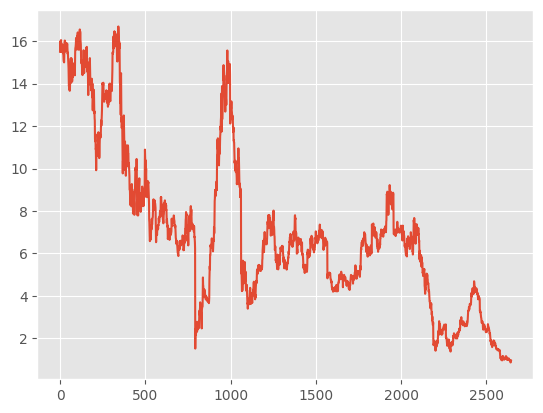

In [835]:
plt.plot(data)

plt.show()

In [836]:
data.shape

(2645,)

In [837]:
scaler = MinMaxScaler((0, 1))

data = scaler.fit_transform(data.reshape(-1, 1)).T[0]

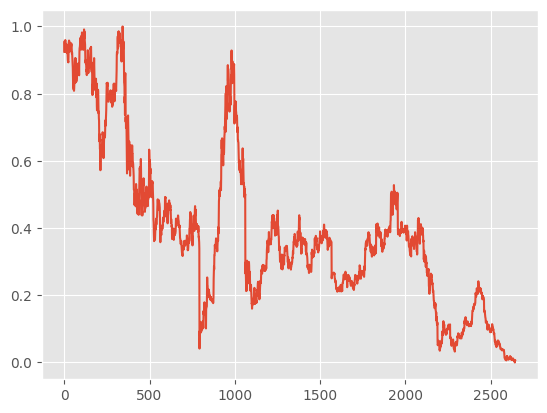

In [839]:
plt.plot(data)

In [842]:
data_tensor = torch.FloatTensor(data)
data0 = data_tensor[0]

In [2]:
def ornstein_uhlenbeck_process(n, m, mu):
    res = []
    theta = 1
    sigma = 0.5
    # mu = 0.0
    T = 1
    
    for j in range(m):
        x = np.zeros(n + 1)
        s = np.zeros(n + 1)
        time = np.zeros(n + 1)
        
        x[0] = np.random.normal(0, 0.1)
        dt = T/float(n)

        for t in range(n):
            x[t+1] = x[t] + theta*(mu - x[t]) * dt + sigma * np.sqrt(dt) * np.random.normal(loc=0, scale=1)
            time[t+1] = time[t] + dt

        res.append(x)
    
    return np.array(res).T

def dclProcess(N, M):
    T = 1
    theta = 10
    delta = 8

    Z1 = np.random.normal(0.0, 1.0, [M, N])
    X = np.zeros([M, N + 1])

    X[:, 0] = np.random.normal(0.0, 0.2, M)

    time = np.zeros([N+1])
    dt = T / float(N)
    
    for i in range(0, N):

        X[:,i+1] = X[:, i] - 1/theta * X[:,i] * dt + np.sqrt((1 - (X[:, i])**2)/(theta * (delta + 1))) * np.sqrt(dt) * Z1[:,i]
            
        if (X[:,i+1] > 1).any():
            X[np.where(X[:,i+1] >= 1)[0], i+1] = 0.9999

        if (X[:,i+1] < -1).any():
            X[np.where(X[:,i+1] <= -1)[0], i+1] = -0.9999 
            
        time[i+1] = time[i] + dt

    return X.T

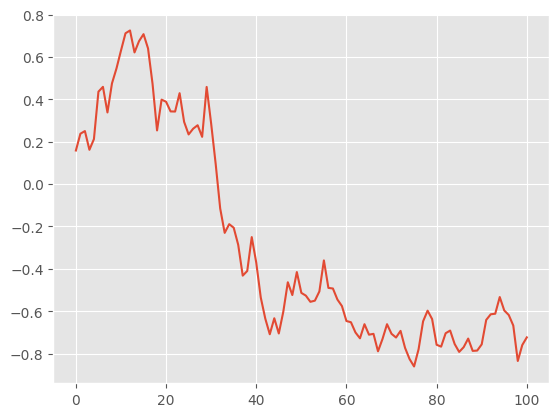

In [12]:
plt.plot(dclProcess(100, 20).T[1])

In [787]:
# plt.plot(np.mean(ornstein_uhlenbeck_process(200, 1000, 0.0).T, axis=0))

In [18]:
def split_series_adapted(x):
    k = 2
    train_sample = []

    for _ in range(1, len(x)):
        train_sample.append(x[:k])
        k += 1

    return train_sample

In [19]:
z_train = split_series_adapted(z)

In [21]:
# data_train = split_series_adapted(data)

In [39]:
np.r_[0., np.random.randn(10 - 1).cumsum()]

array([ 0.        ,  0.26276501,  0.2421158 , -0.92350947, -2.07381846,
       -0.89011455, -1.23960847, -2.03035066, -1.29929728,  0.2378692 ])

# Baseline

### Data

In [434]:
def dclProcess(N, M):
    T = 1
    theta = 10
    delta = 8

    Z1 = np.random.normal(0.0, 1.0, [M, N])
    X = np.zeros([M, N + 1])

    X[:, 0] = np.random.normal(0.0, 0.2, M)

    time = np.zeros([N+1])
    dt = T / float(N)
    
    for i in range(0, N):

        X[:,i+1] = X[:, i] - 1/theta * X[:,i] * dt + np.sqrt((1 - (X[:, i])**2)/(theta * (delta + 1))) * np.sqrt(dt) * Z1[:,i]
            
        if (X[:,i+1] > 1).any():
            X[np.where(X[:,i+1] >= 1)[0], i+1] = 0.9999

        if (X[:,i+1] < -1).any():
            X[np.where(X[:,i+1] <= -1)[0], i+1] = -0.9999 
            
        time[i+1] = time[i] + dt

    return X.T

def merton_process(s0, xiP, muj, sigmaj, r, sigma, n, T):
        time = np.zeros(n + 1)
        dt = T/float(n)
        
        z = np.random.normal(0.0, 1.0, n + 1)
        zj = np.random.normal(muj, sigmaj, n + 1)
        poisson_distr = np.random.poisson(xiP * dt, n + 1)
        
        x = np.zeros(n + 1)
        s = np.zeros(n + 1)
        
        s[0] = s0
        x[0] = np.log(s0)
        
        EeJ = np.exp(muj + 0.5 * sigmaj**2)

        for t in range(n):
            x[t+1] = x[t] + (r - xiP * (EeJ - 1) - 0.5 * sigma**2) * dt +\
                sigma * np.sqrt(dt) * z[t] + zj[t] * poisson_distr[t]
            
            time[t+1] = time[t] + dt
            
        s = np.exp(x)
        
        return s
    
def geometric_BM(s0, mu, sigma, n, T):
        x = np.zeros(n + 1)
        s = np.zeros(n + 1)
        time = np.zeros(n + 1)
        
        x[0] = np.log(s0)
        dt = T/float(n)
        
        for t in range(n):
            x[t+1] = x[t] + (mu - (sigma**2)/2) * dt + sigma * np.sqrt(dt) * np.random.normal(0, 1)
            time[t+1] = time[t] + dt
            
        s = np.exp(x)
        
        return s

In [443]:
# data = dclProcess(2000, 1).T[0]
# data = merton_process(s0=1, xiP=3, muj=0, sigmaj=0.2, r=0.04, sigma=0.15, n=2000, T=1)
data = geometric_BM(s0=1, mu=0.1, sigma=0.5, n=2000, T=1)

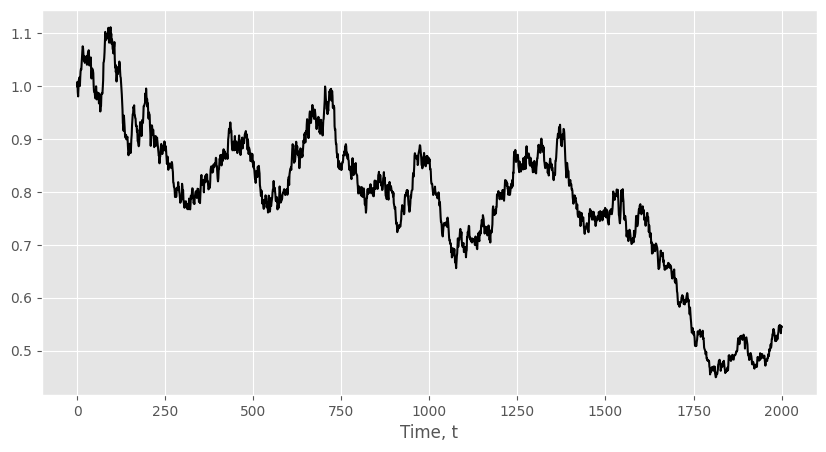

In [444]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(data, color='black')

plt.xlabel('Time, t')
plt.show()

In [841]:
data_tensor = torch.FloatTensor(data)
data0 = data_tensor[0]

In [703]:
def real_data_loading(data: np.array, seq_len):
    ori_data = data[::]
    # Preprocess the dataset
    temp_data = []
    # Cut data by sequence length
    for i in range(0, len(ori_data) - seq_len + 1):
        _x = ori_data[i:i + seq_len]
        temp_data.append(_x)

    # Mix the datasets (to make it similar to i.i.d)
    idx = np.random.permutation(len(temp_data))
    data = []
    for i in range(len(temp_data)):
        data.append(temp_data[idx[i]])
    return data

In [723]:
data_windows = real_data_loading(data.reshape(-1, 1), 128)

In [724]:
dataloader = DataLoader(data_windows, batch_size=64, shuffle=True)

In [725]:
# data_tensor = torch.diff(data_tensor)

In [726]:
# torch.cumsum(torch.cat([data0.unsqueeze(0), data_tensor], dim=0), dim=0)

In [727]:
next(iter(dataloader)).size()

torch.Size([64, 128, 1])

### Modules

In [844]:
class Phi(nn.Module):
    def __init__(self, z_dim, h_dim, data_dim):
        super(Phi, self).__init__()
        
        self.z_dim = z_dim
        self.h_dim = h_dim
        self.data_dim = data_dim
        
        self.model = nn.Sequential(nn.Linear(self.z_dim, 2**7),
                                   nn.ReLU(),
                                   nn.Linear(2**7, 2**7),
                                   nn.ReLU(),
                                   nn.Linear(2**7, self.h_dim))
        
        self.linear = nn.Sequential(nn.Linear(self.data_dim, self.h_dim),
                                    nn.ReLU(),
                                    nn.Linear(self.h_dim, self.h_dim))
        
    def forward(self, x, x0):
        out = self.model(x)
        out_x0 = self.linear(x0)
        
        return out + out_x0


class Drift(nn.Module):
    def __init__(self, h_dim):
        super(Drift, self).__init__()

        self.h_dim = h_dim

        self.model = nn.Sequential(nn.Linear(self.h_dim, 2**7),
                                   nn.ReLU(),
                                   nn.Linear(2**7, 2**7),
                                   nn.ReLU(),
                                   nn.Linear(2**7, self.h_dim))
        
        self.t_nn = nn.Sequential(nn.Linear(1, 2**6),
                                  nn.Tanh(),
                                  nn.Linear(2**6, self.h_dim),
                                  nn.Tanh())

    def forward(self, t, x):
        out = self.model(x)
        out_t = self.t_nn(t)
        
        return out + out_t
    
class Diffusion(nn.Module):
    def __init__(self, h_dim):
        super(Diffusion, self).__init__()

        self.h_dim = h_dim

        self.model = nn.Sequential(nn.Linear(self.h_dim, 2**7),
                                   nn.ReLU(),
                                   nn.Linear(2**7, 2**7),
                                   nn.ReLU(),
                                   nn.Linear(2**7, self.h_dim))
        
        self.t_nn = nn.Sequential(nn.Linear(1, 2**6),
                                  nn.Tanh(),
                                  nn.Linear(2**6, self.h_dim),
                                  nn.Tanh())

    def forward(self, t, x):
        out = self.model(x)
        out_t = self.t_nn(t)
        
        return out + out_t
    
class Operator_F(nn.Module):
    def __init__(self, h_dim, data_dim):
        super(Operator_F, self).__init__()

        self.h_dim = h_dim
        self.data_dim = data_dim

        self.model = nn.Sequential(nn.Linear(self.h_dim, 2**7),
                                   nn.ReLU(),
                                   nn.Linear(2**7, 2**7),
                                   nn.ReLU(),
                                   nn.Linear(2**7, self.data_dim),
                                   nn.Sigmoid())

    def forward(self, x):
        out = self.model(x)
        return out
    
class Operator_G(nn.Module):
    def __init__(self, h_dim, data_dim):
        super(Operator_G, self).__init__()

        self.h_dim = h_dim
        self.data_dim = data_dim

        self.model = nn.Sequential(nn.Linear(self.h_dim, 2**7),
                                   nn.ReLU(),
                                   nn.Linear(2**7, 2**7),
                                   nn.ReLU(),
                                   nn.Linear(2**7, self.data_dim))

    def forward(self, x):
        out = self.model(x)
        return out

In [845]:
class JSD(nn.Module):
    def __init__(self):
        super(JSD, self).__init__()
        self.kl = nn.KLDivLoss(reduction='batchmean', log_target=True)

    def forward(self, p: torch.tensor, q: torch.tensor):
        p, q = F.softmax(p.view(-1, p.size(-1))), F.softmax(q.view(-1, q.size(-1)))
        m = (0.5 * (p + q)).log()
        
        return 0.5 * (self.kl(m, p.log()) + self.kl(m, q.log()))

In [846]:
def sdeint(drift, diffusion, dt, x0, n, h_dim):
    solution = []
    solution.append(x0)
    t = torch.FloatTensor([0])
    
    for i in range(n - 1):
        x_next = solution[i] + drift(t, solution[i].view(1, -1)) * torch.sqrt(dt) +\
            diffusion(t, solution[i].view(1, -1)) * torch.sqrt(dt) * torch.FloatTensor(np.random.normal(0, 1, size=(1, h_dim)))
            
        t = t + dt
            
        solution.append(x_next)
        
    solution = torch.stack(solution, 1).squeeze()
        
    return solution

## Train

In [847]:
z_dim = 15
h_dim = 128
data_dim = 1

phi = Phi(z_dim, h_dim, data_dim)
drift = Drift(h_dim)
diffusion = Diffusion(h_dim)
f = Operator_F(h_dim, data_dim)
g = Operator_G(h_dim, data_dim)

optim_phi = optim.Adam(phi.parameters(), lr=3e-4, betas=(0.9, 0.999), amsgrad=True)
optim_drift = optim.Adam(drift.parameters(), lr=3e-4, betas=(0.9, 0.999), amsgrad=True)
optim_diffusion = optim.Adam(diffusion.parameters(), lr=3e-4, betas=(0.9, 0.999), amsgrad=True)
optim_f = optim.Adam(f.parameters(), lr=3e-4, betas=(0.9, 0.999), amsgrad=True)
optim_g = optim.Adam(g.parameters(), lr=3e-4, betas=(0.9, 0.999), amsgrad=True)

In [848]:
epochs = tqdm(range(200))
# torch.autograd.set_detect_anomaly(False)

for _ in epochs:
    # loss = nn.MSELoss()
    loss2 = nn.MSELoss()
    jsd = JSD()
    nll = nn.GaussianNLLLoss()
    
    #Batch 
    # ------------------------
    # for data_batch in dataloader:

        
    #     x_tensor = torch.FloatTensor([])
    #     criterion_array = torch.FloatTensor([0.0])
        
    #     for data_tensor in data_batch:

    #         noise = torch.FloatTensor(dclProcess(1, z_dim))[1]
    #         dt = torch.FloatTensor([1/len(data_tensor)])
            
    #         xi0 = phi(noise).unsqueeze(0)
            
    #         # print(next(iter(phi.parameters())))

    #         xi = sdeint(drift, diffusion, dt, xi0, len(data_tensor), h_dim)
    #         x = f(xi)
            
    #         x_tensor = torch.cat([x_tensor, x], dim=0)
    
    #         criterion = 0.3 * nll(torch.diff(x, 1), torch.diff(data_tensor, 1), torch.ones_like(torch.diff(data_tensor, 1))) +\
    #             0.1 * torch.abs(f(xi0).squeeze() - data0)**2 + 0.3 * jsd(data_tensor, x.view(-1)) + 0.3 * loss2(data_tensor, x.view(-1))
        
    #         criterion_array = criterion_array + criterion
    #     print(criterion_array)
    #     criterion = criterion_array
    # -------------------------
    
    
    noise = torch.mean(torch.FloatTensor(dclProcess(10, z_dim)), dim=0)
    dt = torch.FloatTensor([1/len(data_tensor)])
    xi0 = phi(noise, data0.unsqueeze(0)).unsqueeze(0)
    

    xi = sdeint(drift, diffusion, dt, xi0, len(data_tensor), h_dim)
    x = f(xi)

    # criterion = 0.3 * loss2(data_tensor, x.view(-1)) + 0.4 * jsd(data_tensor, x.view(-1)) + 0.3 * torch.abs(f(xi0).squeeze() - data0)**2
    # criterion = jsd(torch.FloatTensor(data), x.view(-1))
    # criterion = 0.4 * nll(torch.diff(x.view(-1), 1), torch.diff(data_tensor, 1), torch.ones_like(torch.diff(data_tensor, 1))) +\
    criterion = 0.2 * torch.abs(f(xi0).squeeze() - data0)**2 + 0.4 * jsd(data_tensor, x.view(-1)) + 0.4 * loss2(data_tensor, x.view(-1))
        
 


    optim_phi.zero_grad()
    optim_drift.zero_grad()
    optim_diffusion.zero_grad()
    f.zero_grad()
    # g.zero_grad()

    criterion.backward()
    
    optim_phi.step()
    optim_drift.step()
    optim_diffusion.step()
    optim_f.step()
    # optim_g.step()

    epochs.set_description(f'Loss {criterion.item()}')

Loss 0.004880807362496853: 100%|██████████| 200/200 [04:02<00:00,  1.21s/it] 


In [849]:
def sample(z_dim, h_dim, phi, drift, diffusion, f, g, data):
    
    noise = torch.mean(torch.FloatTensor(dclProcess(10, z_dim)), dim=0)   
    xi0 = phi(noise, data0.unsqueeze(0)).unsqueeze(0)

    x = sdeint(drift, diffusion, dt, xi0, len(data), h_dim)
    x = f(x)
    
    return x.detach().cpu().numpy()

In [850]:
x_array = []
for i in range(10):
    gen_path = sample(z_dim, h_dim, phi, drift, diffusion, f, g, data_tensor)
    # gen_path = torch.cumsum(torch.cat([data0.unsqueeze(0), torch.FloatTensor(gen_path).view(1, -1).squeeze()], dim=0), dim=0)
    x_array.append(gen_path)
    
x_array = np.array(x_array, dtype=object)
x_array = x_array.T[0]

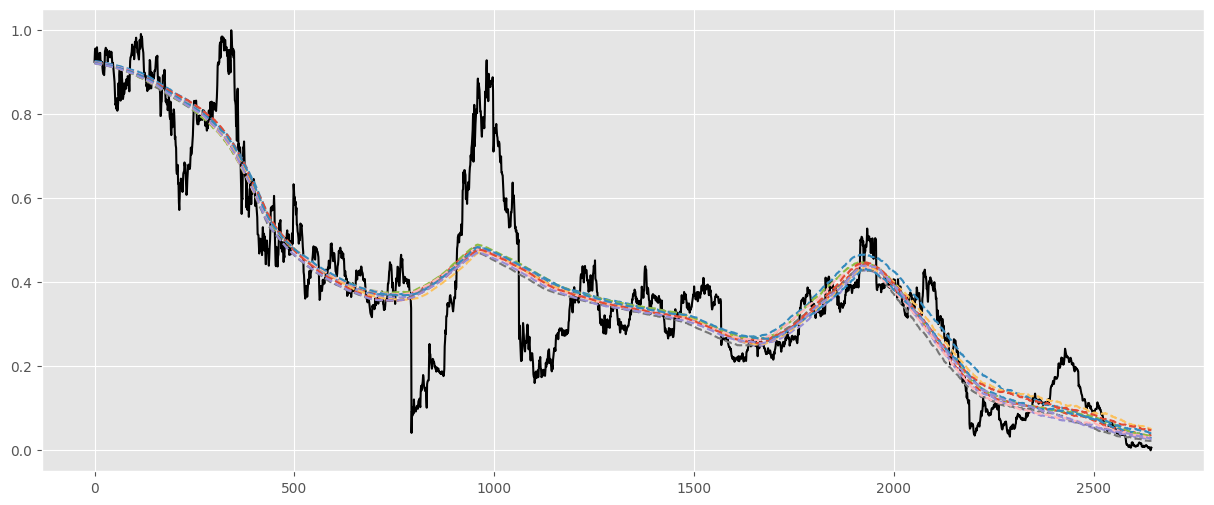

In [851]:
plt.subplots(figsize=(15, 6), dpi=100)

plt.plot(data, color='black')
plt.plot(x_array, '--')

plt.show()

In [141]:
def log_normal_pdf(x, mean, var):
    x_norm = (x - mean)**2 / (var + 1e-5)
    const = torch.from_numpy(np.array([2. * np.pi])).float()
    const = torch.log(const)
    logvar = torch.log(var)
    pdf = -.5 * (const + logvar + x_norm)
    
    return pdf

def calculate_log_likelihood(sample_paths, real_path):
    mean = torch.mean(torch.diff(sample_paths, dim=1), dim=0) 
    var = torch.var(torch.diff(sample_paths, dim=1), dim=0)
    x = torch.diff(real_path)
    log_pdf = log_normal_pdf(x, mean, var + 1e-5)
    
    return log_pdf.mean()

In [ ]:
x = torch.FloatTensor([0, 1, 2, 0])
xhat = torch.FloatTensor([[0, 2, 1, 0], [0, 1, 2, 1]])

In [140]:
sts.norm.logpdf(x)

array([-0.91893853, -1.41893853, -2.91893853, -0.91893853])

In [135]:
log_normal_pdf(x, torch.FloatTensor([0]), torch.FloatTensor([1]))

tensor([-0.9189, -1.4189, -2.9189, -0.9189])

In [142]:
calculate_log_likelihood(xhat, x)

tensor(-8332.5000)

In [ ]:
       #likelihood loss
        #------------------------
        # x_array = []
        # for i in range(50):
        #     xi = sdeint(drift, diffusion, dt, xi0, len(data), h_dim)
        #     x = f(xi)
            
        #     x_array.append(x)
            
        # x = torch.stack(x_array, 1).view(1, 50, -1).squeeze()
        
        # criterion2 = - calculate_log_likelihood(x, data_tensor)
        

        # reg_lambda = 0.1
        # reg = torch.tensor(0.) 
        
        # for param in f.parameters():
        #     reg += torch.norm(param, 1)
            
        # criterion2 += reg_lambda * reg
        #------------------------

In [25]:
data_train = list(map(lambda x: torch.FloatTensor(x.reshape(-1, 1)), data_train))

In [26]:
data_train = data_train[:10]

In [187]:
# train_loader = DataLoader(data_train, shuffle=False)

In [27]:
epochs = tqdm(range(1000))

for _ in epochs:
    for idx in range(len(data_train)):
        loss = nn.MSELoss()

        noise = torch.FloatTensor(z_train[idx].reshape(-1, 1))

        a = torch.sum(drift(noise))
        b = torch.sum(diffusion(noise))
        print(a)
        x = np.zeros(len(noise))
        dt = 0.1
        for i in range(len(noise) - 1):
            x[i+1] = x[i] + a * dt + b * torch.sqrt(dt) * np.random.normal(0, 1)

        x = Variable(torch.FloatTensor(x.reshape(-1, 1)), requires_grad=True)

        criterion = loss(data_train[idx], x)

        optim_drift.zero_grad()
        optim_diffusion.zero_grad()

        criterion.backward()

        optim_drift.step()
        optim_diffusion.step()

    epochs.set_description(f'Loss {criterion.item()}')


Loss 235.6501922607422:   3%|▎         | 31/1000 [00:00<00:05, 169.43it/s] 

tensor(0.2208, grad_fn=<SumBackward0>)
tensor(0.3311, grad_fn=<SumBackward0>)
tensor(0.4413, grad_fn=<SumBackward0>)
tensor(0.5516, grad_fn=<SumBackward0>)
tensor(0.6617, grad_fn=<SumBackward0>)
tensor(0.7717, grad_fn=<SumBackward0>)
tensor(0.8815, grad_fn=<SumBackward0>)
tensor(0.9912, grad_fn=<SumBackward0>)
tensor(1.1008, grad_fn=<SumBackward0>)
tensor(1.2103, grad_fn=<SumBackward0>)
tensor(0.2208, grad_fn=<SumBackward0>)
tensor(0.3311, grad_fn=<SumBackward0>)
tensor(0.4413, grad_fn=<SumBackward0>)
tensor(0.5516, grad_fn=<SumBackward0>)
tensor(0.6617, grad_fn=<SumBackward0>)
tensor(0.7717, grad_fn=<SumBackward0>)
tensor(0.8815, grad_fn=<SumBackward0>)
tensor(0.9912, grad_fn=<SumBackward0>)
tensor(1.1008, grad_fn=<SumBackward0>)
tensor(1.2103, grad_fn=<SumBackward0>)
tensor(0.2208, grad_fn=<SumBackward0>)
tensor(0.3311, grad_fn=<SumBackward0>)
tensor(0.4413, grad_fn=<SumBackward0>)
tensor(0.5516, grad_fn=<SumBackward0>)
tensor(0.6617, grad_fn=<SumBackward0>)
tensor(0.7717, grad_fn=<S

Loss 224.97581481933594:   8%|▊         | 81/1000 [00:00<00:04, 221.06it/s]

tensor(0.2208, grad_fn=<SumBackward0>)
tensor(0.3311, grad_fn=<SumBackward0>)
tensor(0.4413, grad_fn=<SumBackward0>)
tensor(0.5516, grad_fn=<SumBackward0>)
tensor(0.6617, grad_fn=<SumBackward0>)
tensor(0.7717, grad_fn=<SumBackward0>)
tensor(0.8815, grad_fn=<SumBackward0>)
tensor(0.9912, grad_fn=<SumBackward0>)
tensor(1.1008, grad_fn=<SumBackward0>)
tensor(1.2103, grad_fn=<SumBackward0>)
tensor(0.2208, grad_fn=<SumBackward0>)
tensor(0.3311, grad_fn=<SumBackward0>)
tensor(0.4413, grad_fn=<SumBackward0>)
tensor(0.5516, grad_fn=<SumBackward0>)
tensor(0.6617, grad_fn=<SumBackward0>)
tensor(0.7717, grad_fn=<SumBackward0>)
tensor(0.8815, grad_fn=<SumBackward0>)
tensor(0.9912, grad_fn=<SumBackward0>)
tensor(1.1008, grad_fn=<SumBackward0>)
tensor(1.2103, grad_fn=<SumBackward0>)
tensor(0.2208, grad_fn=<SumBackward0>)
tensor(0.3311, grad_fn=<SumBackward0>)
tensor(0.4413, grad_fn=<SumBackward0>)
tensor(0.5516, grad_fn=<SumBackward0>)
tensor(0.6617, grad_fn=<SumBackward0>)
tensor(0.7717, grad_fn=<S

Loss 227.90399169921875:  13%|█▎        | 130/1000 [00:00<00:03, 231.36it/s]

tensor(0.2208, grad_fn=<SumBackward0>)
tensor(0.3311, grad_fn=<SumBackward0>)
tensor(0.4413, grad_fn=<SumBackward0>)
tensor(0.5516, grad_fn=<SumBackward0>)
tensor(0.6617, grad_fn=<SumBackward0>)
tensor(0.7717, grad_fn=<SumBackward0>)
tensor(0.8815, grad_fn=<SumBackward0>)
tensor(0.9912, grad_fn=<SumBackward0>)
tensor(1.1008, grad_fn=<SumBackward0>)
tensor(1.2103, grad_fn=<SumBackward0>)
tensor(0.2208, grad_fn=<SumBackward0>)
tensor(0.3311, grad_fn=<SumBackward0>)
tensor(0.4413, grad_fn=<SumBackward0>)
tensor(0.5516, grad_fn=<SumBackward0>)
tensor(0.6617, grad_fn=<SumBackward0>)
tensor(0.7717, grad_fn=<SumBackward0>)
tensor(0.8815, grad_fn=<SumBackward0>)
tensor(0.9912, grad_fn=<SumBackward0>)
tensor(1.1008, grad_fn=<SumBackward0>)
tensor(1.2103, grad_fn=<SumBackward0>)
tensor(0.2208, grad_fn=<SumBackward0>)
tensor(0.3311, grad_fn=<SumBackward0>)
tensor(0.4413, grad_fn=<SumBackward0>)
tensor(0.5516, grad_fn=<SumBackward0>)
tensor(0.6617, grad_fn=<SumBackward0>)
tensor(0.7717, grad_fn=<S

Loss 243.2301788330078:  18%|█▊        | 178/1000 [00:00<00:03, 225.55it/s] 

tensor(0.2208, grad_fn=<SumBackward0>)
tensor(0.3311, grad_fn=<SumBackward0>)
tensor(0.4413, grad_fn=<SumBackward0>)
tensor(0.5516, grad_fn=<SumBackward0>)
tensor(0.6617, grad_fn=<SumBackward0>)
tensor(0.7717, grad_fn=<SumBackward0>)
tensor(0.8815, grad_fn=<SumBackward0>)
tensor(0.9912, grad_fn=<SumBackward0>)
tensor(1.1008, grad_fn=<SumBackward0>)
tensor(1.2103, grad_fn=<SumBackward0>)
tensor(0.2208, grad_fn=<SumBackward0>)
tensor(0.3311, grad_fn=<SumBackward0>)
tensor(0.4413, grad_fn=<SumBackward0>)
tensor(0.5516, grad_fn=<SumBackward0>)
tensor(0.6617, grad_fn=<SumBackward0>)
tensor(0.7717, grad_fn=<SumBackward0>)
tensor(0.8815, grad_fn=<SumBackward0>)
tensor(0.9912, grad_fn=<SumBackward0>)
tensor(1.1008, grad_fn=<SumBackward0>)
tensor(1.2103, grad_fn=<SumBackward0>)
tensor(0.2208, grad_fn=<SumBackward0>)
tensor(0.3311, grad_fn=<SumBackward0>)
tensor(0.4413, grad_fn=<SumBackward0>)
tensor(0.5516, grad_fn=<SumBackward0>)
tensor(0.6617, grad_fn=<SumBackward0>)
tensor(0.7717, grad_fn=<S

Loss 236.67796325683594:  23%|██▎       | 227/1000 [00:01<00:03, 234.17it/s]

tensor(0.7717, grad_fn=<SumBackward0>)
tensor(0.8815, grad_fn=<SumBackward0>)
tensor(0.9912, grad_fn=<SumBackward0>)
tensor(1.1008, grad_fn=<SumBackward0>)
tensor(1.2103, grad_fn=<SumBackward0>)
tensor(0.2208, grad_fn=<SumBackward0>)
tensor(0.3311, grad_fn=<SumBackward0>)
tensor(0.4413, grad_fn=<SumBackward0>)
tensor(0.5516, grad_fn=<SumBackward0>)
tensor(0.6617, grad_fn=<SumBackward0>)
tensor(0.7717, grad_fn=<SumBackward0>)
tensor(0.8815, grad_fn=<SumBackward0>)
tensor(0.9912, grad_fn=<SumBackward0>)
tensor(1.1008, grad_fn=<SumBackward0>)
tensor(1.2103, grad_fn=<SumBackward0>)
tensor(0.2208, grad_fn=<SumBackward0>)
tensor(0.3311, grad_fn=<SumBackward0>)
tensor(0.4413, grad_fn=<SumBackward0>)
tensor(0.5516, grad_fn=<SumBackward0>)
tensor(0.6617, grad_fn=<SumBackward0>)
tensor(0.7717, grad_fn=<SumBackward0>)
tensor(0.8815, grad_fn=<SumBackward0>)
tensor(0.9912, grad_fn=<SumBackward0>)
tensor(1.1008, grad_fn=<SumBackward0>)
tensor(1.2103, grad_fn=<SumBackward0>)
tensor(0.2208, grad_fn=<S

Loss 228.2172393798828:  28%|██▊       | 276/1000 [00:01<00:03, 237.68it/s] 

tensor(0.2208, grad_fn=<SumBackward0>)
tensor(0.3311, grad_fn=<SumBackward0>)
tensor(0.4413, grad_fn=<SumBackward0>)
tensor(0.5516, grad_fn=<SumBackward0>)
tensor(0.6617, grad_fn=<SumBackward0>)
tensor(0.7717, grad_fn=<SumBackward0>)
tensor(0.8815, grad_fn=<SumBackward0>)
tensor(0.9912, grad_fn=<SumBackward0>)
tensor(1.1008, grad_fn=<SumBackward0>)
tensor(1.2103, grad_fn=<SumBackward0>)
tensor(0.2208, grad_fn=<SumBackward0>)
tensor(0.3311, grad_fn=<SumBackward0>)
tensor(0.4413, grad_fn=<SumBackward0>)
tensor(0.5516, grad_fn=<SumBackward0>)
tensor(0.6617, grad_fn=<SumBackward0>)
tensor(0.7717, grad_fn=<SumBackward0>)
tensor(0.8815, grad_fn=<SumBackward0>)
tensor(0.9912, grad_fn=<SumBackward0>)
tensor(1.1008, grad_fn=<SumBackward0>)
tensor(1.2103, grad_fn=<SumBackward0>)
tensor(0.2208, grad_fn=<SumBackward0>)
tensor(0.3311, grad_fn=<SumBackward0>)
tensor(0.4413, grad_fn=<SumBackward0>)
tensor(0.5516, grad_fn=<SumBackward0>)
tensor(0.6617, grad_fn=<SumBackward0>)
tensor(0.7717, grad_fn=<S

Loss 225.51739501953125:  32%|███▎      | 325/1000 [00:01<00:02, 239.48it/s]

tensor(0.3311, grad_fn=<SumBackward0>)
tensor(0.4413, grad_fn=<SumBackward0>)
tensor(0.5516, grad_fn=<SumBackward0>)
tensor(0.6617, grad_fn=<SumBackward0>)
tensor(0.7717, grad_fn=<SumBackward0>)
tensor(0.8815, grad_fn=<SumBackward0>)
tensor(0.9912, grad_fn=<SumBackward0>)
tensor(1.1008, grad_fn=<SumBackward0>)
tensor(1.2103, grad_fn=<SumBackward0>)
tensor(0.2208, grad_fn=<SumBackward0>)
tensor(0.3311, grad_fn=<SumBackward0>)
tensor(0.4413, grad_fn=<SumBackward0>)
tensor(0.5516, grad_fn=<SumBackward0>)
tensor(0.6617, grad_fn=<SumBackward0>)
tensor(0.7717, grad_fn=<SumBackward0>)
tensor(0.8815, grad_fn=<SumBackward0>)
tensor(0.9912, grad_fn=<SumBackward0>)
tensor(1.1008, grad_fn=<SumBackward0>)
tensor(1.2103, grad_fn=<SumBackward0>)
tensor(0.2208, grad_fn=<SumBackward0>)
tensor(0.3311, grad_fn=<SumBackward0>)
tensor(0.4413, grad_fn=<SumBackward0>)
tensor(0.5516, grad_fn=<SumBackward0>)
tensor(0.6617, grad_fn=<SumBackward0>)
tensor(0.7717, grad_fn=<SumBackward0>)
tensor(0.8815, grad_fn=<S

Loss 230.47291564941406:  37%|███▋      | 374/1000 [00:01<00:02, 241.10it/s]

tensor(0.9912, grad_fn=<SumBackward0>)
tensor(1.1008, grad_fn=<SumBackward0>)
tensor(1.2103, grad_fn=<SumBackward0>)
tensor(0.2208, grad_fn=<SumBackward0>)
tensor(0.3311, grad_fn=<SumBackward0>)
tensor(0.4413, grad_fn=<SumBackward0>)
tensor(0.5516, grad_fn=<SumBackward0>)
tensor(0.6617, grad_fn=<SumBackward0>)
tensor(0.7717, grad_fn=<SumBackward0>)
tensor(0.8815, grad_fn=<SumBackward0>)
tensor(0.9912, grad_fn=<SumBackward0>)
tensor(1.1008, grad_fn=<SumBackward0>)
tensor(1.2103, grad_fn=<SumBackward0>)
tensor(0.2208, grad_fn=<SumBackward0>)
tensor(0.3311, grad_fn=<SumBackward0>)
tensor(0.4413, grad_fn=<SumBackward0>)
tensor(0.5516, grad_fn=<SumBackward0>)
tensor(0.6617, grad_fn=<SumBackward0>)
tensor(0.7717, grad_fn=<SumBackward0>)
tensor(0.8815, grad_fn=<SumBackward0>)
tensor(0.9912, grad_fn=<SumBackward0>)
tensor(1.1008, grad_fn=<SumBackward0>)
tensor(1.2103, grad_fn=<SumBackward0>)
tensor(0.2208, grad_fn=<SumBackward0>)
tensor(0.3311, grad_fn=<SumBackward0>)
tensor(0.4413, grad_fn=<S

Loss 247.512451171875:  40%|███▉      | 399/1000 [00:01<00:02, 234.21it/s]  

tensor(0.2208, grad_fn=<SumBackward0>)
tensor(0.3311, grad_fn=<SumBackward0>)
tensor(0.4413, grad_fn=<SumBackward0>)
tensor(0.5516, grad_fn=<SumBackward0>)
tensor(0.6617, grad_fn=<SumBackward0>)
tensor(0.7717, grad_fn=<SumBackward0>)
tensor(0.8815, grad_fn=<SumBackward0>)
tensor(0.9912, grad_fn=<SumBackward0>)
tensor(1.1008, grad_fn=<SumBackward0>)
tensor(1.2103, grad_fn=<SumBackward0>)
tensor(0.2208, grad_fn=<SumBackward0>)
tensor(0.3311, grad_fn=<SumBackward0>)
tensor(0.4413, grad_fn=<SumBackward0>)
tensor(0.5516, grad_fn=<SumBackward0>)
tensor(0.6617, grad_fn=<SumBackward0>)
tensor(0.7717, grad_fn=<SumBackward0>)
tensor(0.8815, grad_fn=<SumBackward0>)
tensor(0.9912, grad_fn=<SumBackward0>)
tensor(1.1008, grad_fn=<SumBackward0>)
tensor(1.2103, grad_fn=<SumBackward0>)
tensor(0.2208, grad_fn=<SumBackward0>)
tensor(0.3311, grad_fn=<SumBackward0>)
tensor(0.4413, grad_fn=<SumBackward0>)
tensor(0.5516, grad_fn=<SumBackward0>)
tensor(0.6617, grad_fn=<SumBackward0>)
tensor(0.7717, grad_fn=<S

Loss 248.69166564941406:  45%|████▍     | 448/1000 [00:02<00:02, 226.62it/s]

tensor(0.9912, grad_fn=<SumBackward0>)
tensor(1.1008, grad_fn=<SumBackward0>)
tensor(1.2103, grad_fn=<SumBackward0>)
tensor(0.2208, grad_fn=<SumBackward0>)
tensor(0.3311, grad_fn=<SumBackward0>)
tensor(0.4413, grad_fn=<SumBackward0>)
tensor(0.5516, grad_fn=<SumBackward0>)
tensor(0.6617, grad_fn=<SumBackward0>)
tensor(0.7717, grad_fn=<SumBackward0>)
tensor(0.8815, grad_fn=<SumBackward0>)
tensor(0.9912, grad_fn=<SumBackward0>)
tensor(1.1008, grad_fn=<SumBackward0>)
tensor(1.2103, grad_fn=<SumBackward0>)
tensor(0.2208, grad_fn=<SumBackward0>)
tensor(0.3311, grad_fn=<SumBackward0>)
tensor(0.4413, grad_fn=<SumBackward0>)
tensor(0.5516, grad_fn=<SumBackward0>)
tensor(0.6617, grad_fn=<SumBackward0>)
tensor(0.7717, grad_fn=<SumBackward0>)
tensor(0.8815, grad_fn=<SumBackward0>)
tensor(0.9912, grad_fn=<SumBackward0>)
tensor(1.1008, grad_fn=<SumBackward0>)
tensor(1.2103, grad_fn=<SumBackward0>)
tensor(0.2208, grad_fn=<SumBackward0>)
tensor(0.3311, grad_fn=<SumBackward0>)
tensor(0.4413, grad_fn=<S

Loss 223.82598876953125:  51%|█████     | 508/1000 [00:02<00:02, 228.97it/s]


tensor(0.3311, grad_fn=<SumBackward0>)
tensor(0.4413, grad_fn=<SumBackward0>)
tensor(0.5516, grad_fn=<SumBackward0>)
tensor(0.6617, grad_fn=<SumBackward0>)
tensor(0.7717, grad_fn=<SumBackward0>)
tensor(0.8815, grad_fn=<SumBackward0>)
tensor(0.9912, grad_fn=<SumBackward0>)
tensor(1.1008, grad_fn=<SumBackward0>)
tensor(1.2103, grad_fn=<SumBackward0>)
tensor(0.2208, grad_fn=<SumBackward0>)
tensor(0.3311, grad_fn=<SumBackward0>)
tensor(0.4413, grad_fn=<SumBackward0>)
tensor(0.5516, grad_fn=<SumBackward0>)
tensor(0.6617, grad_fn=<SumBackward0>)
tensor(0.7717, grad_fn=<SumBackward0>)
tensor(0.8815, grad_fn=<SumBackward0>)
tensor(0.9912, grad_fn=<SumBackward0>)
tensor(1.1008, grad_fn=<SumBackward0>)
tensor(1.2103, grad_fn=<SumBackward0>)
tensor(0.2208, grad_fn=<SumBackward0>)
tensor(0.3311, grad_fn=<SumBackward0>)
tensor(0.4413, grad_fn=<SumBackward0>)
tensor(0.5516, grad_fn=<SumBackward0>)
tensor(0.6617, grad_fn=<SumBackward0>)
tensor(0.7717, grad_fn=<SumBackward0>)
tensor(0.8815, grad_fn=<S

KeyboardInterrupt: 

In [237]:
torch.sum(drift(torch.FloatTensor(z_train[0].reshape(-1, 1))))

tensor(0.0519, grad_fn=<SumBackward0>)

In [243]:
a = torch.sum(drift(torch.FloatTensor(z_train[5].reshape(-1, 1)))).detach().cpu().numpy()
b = torch.sum(diffusion(torch.FloatTensor(z_train[5].reshape(-1, 1)))).detach().cpu().numpy()

x = np.zeros(len(noise) + 1)
dt = 0.1

for i in range(len(z_train[5]) - 1):
    x[i+1] = x[i] + a * dt + b * np.sqrt(dt) * np.random.normal(0, 1)

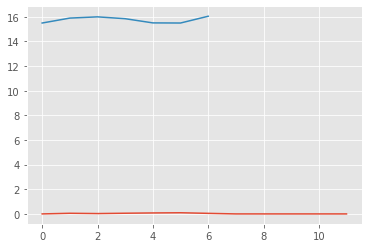

In [244]:
plt.plot(x)
plt.plot(data_train[5])

In [37]:
import candle
import numpy as np
import sdepy
import siglayer

import torch
import torch.nn as nn
import torch.utils.data as torchdata


def gen_data(n_points=100):
    """Generate an Ornstein-Uhlenbeck process."""

    sde = sdepy.ornstein_uhlenbeck_process()
    timeline = np.linspace(0, 1, n_points)
    values = sde(timeline).flatten()
    path = np.c_[timeline, values.tolist()]
    return path.T


def gen_noise(n_points=100):
    """Generate a Brownian motion."""
    
    dt = 1 / np.sqrt(n_points)
    bm = dt * np.r_[0., np.random.randn(n_points - 1).cumsum()]
    timeline = np.linspace(0, 1, n_points)
    return np.c_[timeline, bm].T


def get_signal(num_samples=1000, **kwargs):
    """Generate examples of an Ornstein-Uhlenbeck process."""
    
    paths = np.array([gen_data(**kwargs) for _ in range(num_samples)])
    return torchdata.TensorDataset(torch.tensor(paths, dtype=torch.float))


def get_noise(num_samples=1000, **kwargs):
    """Generate examples of an Brownian motion."""
    
    paths = np.array([gen_noise(**kwargs) for _ in range(num_samples)])
    y = np.zeros_like(paths[:, 0, :-1])
    return torchdata.TensorDataset(torch.tensor(paths, dtype=torch.float), torch.tensor(y, dtype=torch.float))


def scalar_orders(dim, order):
    """The order of the scalar basis elements as one moves along the signature."""
    
    for i in range(order + 1):
        for _ in range(dim ** i):
            yield i


def psi(x, M=4, a=1):
    """Psi function, as defined in the following paper:

    Chevyrev, I. and Oberhauser, H., 2018. Signature moments to
    characterize laws of stochastic processes. arXiv preprint arXiv:1810.10971.

    """

    if x <= M:
        return x
    
    return M + M ** (1 + a) * (M ** (-a) - x ** (-a)) / a
  
    
def normalise_instance(x, order):
    """Normalise signature, following the paper

    Chevyrev, I. and Oberhauser, H., 2018. Signature moments to
    characterize laws of stochastic processes. arXiv preprint arXiv:1810.10971.

    """

    x = torch.cat([torch.tensor([1.], device=x.device), x])

    a = x ** 2
    a[0] -= psi(torch.norm(x))
    
    
    x0 = 1.  # Starting point for Newton-Raphson
    
    moments = torch.tensor([x0 ** (2 * m) for m in range(len(x))], device=x.device)
    polx0 = torch.dot(a, moments)
    
    d_moments = torch.tensor([2 * m * x0 ** (2 * m - 1) for m in range(len(x))], device=x.device)
    d_polx0 = torch.dot(a, d_moments)
    x1 = x0 - polx0 / d_polx0

    if x1 < 0.2:
        x1 = 1.
    
    lambda_ = torch.tensor([x1 ** t for t in scalar_orders(2, order)], device=x.device)

    
    return lambda_ * x


def normalise(x, order):
    """Normalise signature."""

    return torch.stack([normalise_instance(sig, order) for sig in x])


def loss(orig_paths, sig_depth=2, normalise_sigs=True):
    """Loss function is the T statistic defined in
    
    Chevyrev, I. and Oberhauser, H., 2018. Signature moments to
    characterize laws of stochastic processes. arXiv preprint arXiv:1810.10971.

    """
    
    sig = siglayer.Signature(sig_depth)
    orig_signatures = sig(orig_paths)
    if normalise_sigs:
        orig_signatures = normalise(orig_signatures, sig_depth)

    T1 = torch.mean(torch.mm(orig_signatures, orig_signatures.t()))

    def loss_fn(output, *args):
        nonlocal T1, orig_signatures
        T1 = T1.to(device=output.device)
        orig_signatures = orig_signatures.to(device=output.device)
        
        timeline = torch.tensor(np.linspace(0, 1, output.shape[1] + 1), dtype=torch.float32, device=output.device)
        paths = torch.stack([torch.stack([timeline, torch.cat([torch.tensor([0.], device=output.device), path])])
                             for path in output])

        generated_sigs = sig(paths)

        if normalise_sigs:
            generated_sigs = normalise(generated_sigs, sig_depth)

        T2 = torch.mean(torch.mm(orig_signatures, generated_sigs.t()))
        T3 = torch.mean(torch.mm(generated_sigs, generated_sigs.t()))

        return torch.log(T1 - 2 * T2 + T3)

    return loss_fn

ModuleNotFoundError: No module named 'candle'